In [1]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
%matplotlib inline

In [2]:
random_state = 2018

In [3]:
np.random.seed(random_state)

In [4]:
def generate_test_predictions(clf, clf_name, random_state=2018):
    test_data = pd.read_csv('./data/test.csv', low_memory=False, skiprows=0)
    
    X_test = test_data/255
    
    # Generate test predictions    
    y_pred = clf.predict(X_test)
    
    # Write test predictions into a file
    ImageId=list(range(1,test_data.shape[0]+1))
    results = np.column_stack((ImageId,y_pred))
    np.savetxt("%s_predictions.csv" % (clf_name),results,fmt='%i,%i',header='ImageId,Label',comments='')

In [5]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
    Parameters:

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# Read data

In [6]:
data = pd.read_csv('./data/train.csv', low_memory=False, skiprows=0)

In [7]:
images = data.loc[:, data.columns != "label"].values
labels = data["label"].values
n_classes = 10
labels_text = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

print("Dimensionality of images: {}".format(images.shape))
print("Dimensionality of labels: {}".format(labels.shape))

Dimensionality of images: (42000, 784)
Dimensionality of labels: (42000,)


# Data visualization

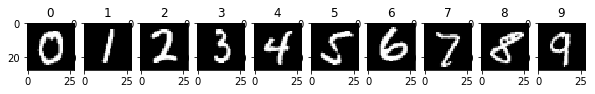

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, n_classes, figsize=(10,10))

idxs = [np.where(labels == i)[0] for i in range(n_classes)]

for i in range(n_classes):
    k = np.random.choice(idxs[i])
    ax[i].imshow(images[k].reshape(28, 28), cmap="gray")
    ax[i].set_title("{}".format(labels_text[i]))

# Split data into train and test set 

In [9]:
from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, stratify=labels)

In [41]:
#### Labels proportion

def labels_proportion(y):

    _, count = np.unique(y, return_counts=True)

    return np.true_divide(count, y.shape[0])


#print("class proportion in original dataset: {}".format(labels_proportion(labels)))
#print("class prooportion in train set: {}".format(labels_proportion(y_train)))
#print("class proportion in test set: {}".format(labels_proportion(y_test)))

_, counts = np.unique(labels, return_counts=True)

sample_size = int(counts.min() * 0.80)

In [11]:
def balanced_sample_maker(X, y, sample_size, random_seed=None):

    """ return a balanced data set by sampling all classes with sample_size

        current version is developed on assumption that the positive

        class is the minority.

    ===========

    X: {numpy.ndarrray}

    y: {numpy.ndarray}

    """

    uniq_levels = np.unique(y)

    uniq_counts = {level: sum(y == level) for level in uniq_levels}

 

    if not random_seed is None:

        np.random.seed(random_seed)

    # find observation index of each class levels
    groupby_levels = {}

    for ii, level in enumerate(uniq_levels):

        obs_idx = [idx for idx, val in enumerate(y) if val == level]

        groupby_levels[level] = obs_idx

    # oversampling on observations of each label
    balanced_copy_idx = []

    for gb_level, gb_idx in groupby_levels.items():

        over_sample_idx = np.random.choice(gb_idx, size=sample_size, replace=True).tolist()

        balanced_copy_idx+=over_sample_idx

    return (X[balanced_copy_idx, :], y[balanced_copy_idx], balanced_copy_idx)

In [42]:
_,_,train_indexes = balanced_sample_maker(images, labels, sample_size)

In [13]:
all_indexes = [row for row in range(0,images.shape[0])]

In [14]:
def list_difference(first, second):
        second = set(second)
        return [item for item in first if item not in second]

test_indexes = list_difference(all_indexes, train_indexes)

In [15]:
X_train = images[train_indexes]
y_train = labels[train_indexes]
X_test = images[test_indexes]
y_test = labels[test_indexes]

In [16]:
print("class proportion in original dataset: {}".format(labels_proportion(labels)))
print("class prooportion in train set: {}".format(labels_proportion(y_train)))
print("class proportion in test set: {}".format(labels_proportion(y_test)))

class proportion in original dataset: [0.09838095 0.11152381 0.09945238 0.10359524 0.09695238 0.09035714
 0.0985     0.10478571 0.0967381  0.09971429]
class prooportion in train set: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
class proportion in test set: [0.09781488 0.12035355 0.09904247 0.10591701 0.09540879 0.08303462
 0.09663639 0.10886325 0.09373926 0.09918979]


## Normalize data

In [17]:
X_train = images[train_indexes] / 255
X_test = images[test_indexes] / 255

# RandomForestClassifier

In [19]:
experiment_id = mlflow.create_experiment("RandomForestClassifier")
print("Experiment id: %d" % experiment_id)

Experiment id: 1


In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

n_trees = 100
cv = 7
criterion = "gini"

with mlflow.start_run(experiment_id=experiment_id):
    
    # Cross validation
    clf = RandomForestClassifier(n_estimators=n_trees, criterion=criterion, random_state=random_state, n_jobs=-1)
    scores = cross_val_score(clf, X_train, y_train, cv=cv)
    cv_accuracy = scores.mean()
    cv_error = scores.std() * 2
    
    #Test 
    clf.fit(X_train, y_train)
    test_accuracy = accuracy_score(y_test, clf.predict(X_test))
    
    # Log params and metrics
    mlflow.log_param("random_state", random_state)
    mlflow.log_param("n_trees", n_trees)
    mlflow.log_param("cv", cv)
    mlflow.log_param("criterion", criterion)
    
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("cv_accuracy", cv_accuracy)
    mlflow.log_metric("cv_error", cv_error)

    print("Accuracy on cross-validation set: %0.4f (+/- %0.4f)" % (cv_accuracy, cv_error))
    print("Accuracy on test set: %0.4f" % test_accuracy)
    
    mlflow.sklearn.log_model(clf, "model")

Accuracy on cross-validation set: 0.9766 (+/- 0.0033)
Accuracy on test set: 0.9623


In [21]:
max_depth_per_tree = np.array([estimator.tree_.max_depth for estimator in clf.estimators_])

max_depth_mean = max_depth_per_tree.mean()
max_depth_max = max_depth_per_tree.max()
max_depth_min = max_depth_per_tree.min()
max_depth_std = max_depth_per_tree.std()

print("Maximum depth stats:")
print("\t max: %0.4f" % (max_depth_max))
print("\t min: %0.4f" % (max_depth_min))
print("\t mean: %0.4f" % (max_depth_mean))
print("\t std: %0.4f" % (max_depth_std))

Maximum depth stats:
	 max: 37.0000
	 min: 23.0000
	 mean: 27.5500
	 std: 2.7582


## Confunsion matrices

### Train set

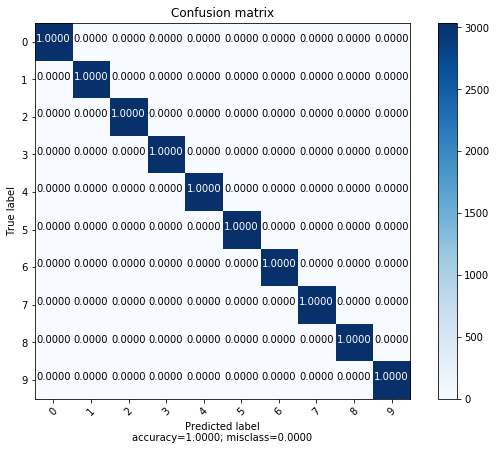

In [22]:
conf_matrix_train = confusion_matrix(y_train, clf.predict(X_train), labels=np.unique(labels))

plot_confusion_matrix(conf_matrix_train, labels_text)

### Test set

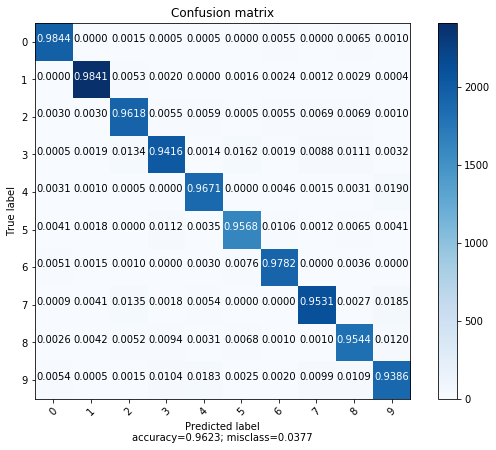

In [23]:
conf_matrix_test = confusion_matrix(y_test, clf.predict(X_test), labels=np.unique(labels))

plot_confusion_matrix(conf_matrix_test, labels_text)

## Generate test predictions

In [24]:
generate_test_predictions(clf, "RandomForestClassifier", random_state=random_state)

# GridSearchCV with RandomForestClassifier

** Please note that this step is very slow, since it has to try all posible combinations described in *param_grid* **

In [25]:
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier()
cv = 3

param_grid = {
    "n_estimators" : [10, 20, 50, 100, 300],
    "criterion" : ["gini", "entropy"],
    "max_features" : ["auto", "log2", "sqrt"],
    "max_depth" : [5,10,20,None],
    "random_state": [random_state]
}

param_grid = {
    "n_estimators" : [10, 20],
    "criterion" : ["entropy"],
    "max_features" : ["auto"],
    "max_depth" : [None],
    "random_state": [random_state]
}

gridSearch = GridSearchCV(estimator=estimator, scoring='accuracy', param_grid=param_grid, cv=cv, verbose=1, n_jobs=-1)

gridSearch.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    6.6s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'random_state': [2018], 'criterion': ['entropy'], 'max_depth': [None], 'max_features': ['auto'], 'n_estimators': [10, 20]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=1)

In [26]:
experiment_id = mlflow.create_experiment("GridSearchCV using RF")
print("Experiment id: %d" % experiment_id)

Experiment id: 2


In [27]:
for score in gridSearch.grid_scores_:
    with mlflow.start_run(experiment_id=experiment_id):
        mlflow.log_param("cv", cv)
        mlflow.log_param("random_state", random_state)

        n_estimators = score.parameters["n_estimators"]
        criterion = score.parameters["criterion"]
        max_features = score.parameters["max_features"]
        max_depth = score.parameters["max_depth"]
        cv_accuracy = score.mean_validation_score

        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("criterion", criterion)
        mlflow.log_param("max_features", max_features)
        mlflow.log_param("max_depth", max_depth)

        mlflow.log_metric("cv_accuracy", cv_accuracy) 

## Confunsion matrices

### Train set

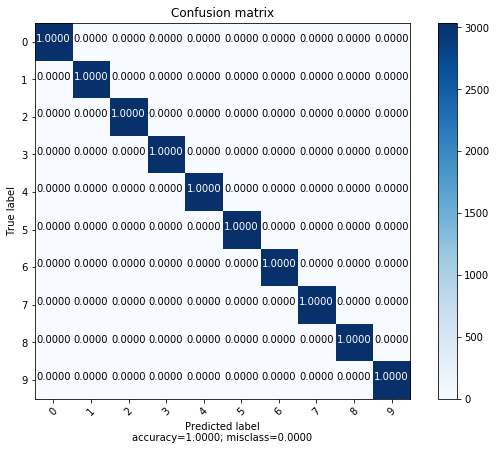

In [28]:
conf_matrix_train = confusion_matrix(y_train, clf.predict(X_train), labels=np.unique(labels))

plot_confusion_matrix(conf_matrix_train, labels_text)

### Test set

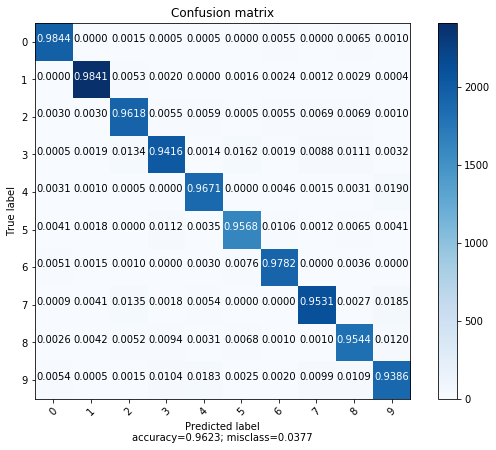

In [29]:
conf_matrix_test = confusion_matrix(y_test, clf.predict(X_test), labels=np.unique(labels))

plot_confusion_matrix(conf_matrix_test, labels_text)

## Generate test predictions

In [30]:
clf = gridSearch.best_estimator_
generate_test_predictions(clf, "GridSearch+RandomForestClassifier", random_state=random_state)

# LDA

In [31]:
experiment_id = mlflow.create_experiment("LDA")
print("Experiment id: %d" % experiment_id)

Experiment id: 3


In [32]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

cv = 7
solver = "svd"
shrinkage=None
tol=0.0001

with mlflow.start_run(experiment_id=experiment_id):

    # Cross-Validation
    clf = LDA(solver=solver, shrinkage=shrinkage, tol=tol)
    scores = cross_val_score(clf, X_train, y_train, cv=cv)
    cv_accuracy = scores.mean()
    cv_error = scores.std() * 2
    
    # Test
    clf.fit(X_train, y_train)
    test_accuracy = accuracy_score(y_test, clf.predict(X_test))
    
    # Log params and metrics
    mlflow.log_param("cv", cv)
    
    mlflow.log_param("solver", solver)
    mlflow.log_param("shrinkage", shrinkage)
    mlflow.log_param("tol", tol)

    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("cv_accuracy", cv_accuracy)
    mlflow.log_metric("cv_error", cv_error)

    print("Accuracy on cross-validation set: %0.4f (+/- %0.4f)" % (cv_accuracy, cv_error))
    print("Accuracy on test set: %0.4f" % test_accuracy)
    
    mlflow.sklearn.log_model(clf, "model")

/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.5/dist-packages/sklearn

Accuracy on cross-validation set: 0.8685 (+/- 0.0056)
Accuracy on test set: 0.8593


## Confusion matrices

### Train set

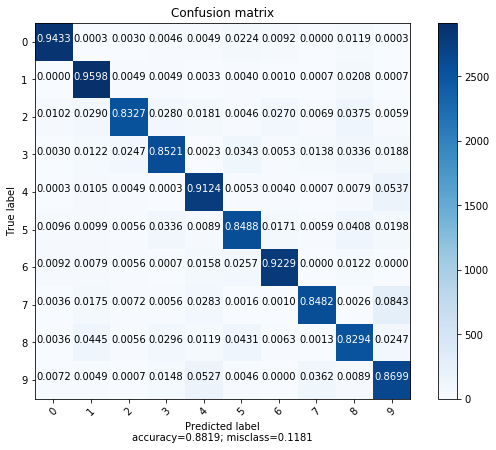

In [33]:
conf_matrix_train = confusion_matrix(y_train, clf.predict(X_train), labels=np.unique(labels))

plot_confusion_matrix(conf_matrix_train, labels_text)

### Test set

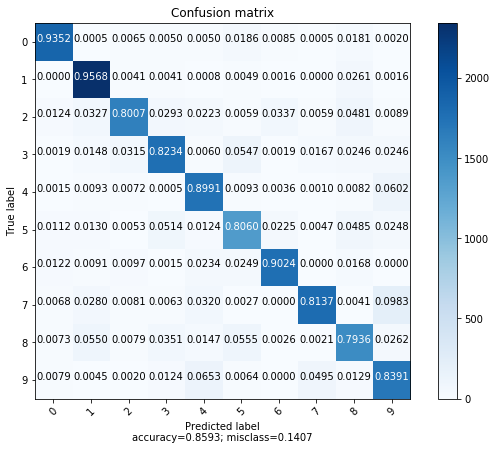

In [34]:
conf_matrix_test = confusion_matrix(y_test, clf.predict(X_test), labels=np.unique(labels))

plot_confusion_matrix(conf_matrix_test, labels_text)

## Generate test predictions

In [35]:
generate_test_predictions(clf, "LDA", random_state=random_state)

# GradientBoostingClassifier

In [36]:
experiment_id = mlflow.create_experiment("GradientBoostingClassifier")
print("Experiment id: %d" % experiment_id)

Experiment id: 4


In [37]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

n_trees = 12
cv = 7
max_depth = 3

with mlflow.start_run(experiment_id=experiment_id):
    
    # Cross-Validation
    clf = GradientBoostingClassifier(n_estimators=n_trees,random_state=random_state, max_depth=max_depth)
    
    scores = cross_val_score(clf, X_train, y_train, cv=cv)
    cv_accuracy = scores.mean()
    cv_error = scores.std() * 2
    
    # Test
    clf.fit(X_train, y_train)
    test_accuracy = accuracy_score(y_test, clf.predict(X_test))
    
    # Log params and metrics
    mlflow.log_param("random_state", random_state)
    mlflow.log_param("n_trees", n_trees)
    mlflow.log_param("cv", cv)
    mlflow.log_param("max_depth", max_depth)
    
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("cv_accuracy", cv_accuracy)
    mlflow.log_metric("cv_error", cv_error)

    print("Accuracy on cross-validation set: %0.4f (+/- %0.4f)" % (cv_accuracy, cv_error))
    print("Accuracy on test set: %0.4f" % test_accuracy)
    
    mlflow.sklearn.log_model(clf, "model")

Accuracy on cross-validation set: 0.8479 (+/- 0.0083)
Accuracy on test set: 0.8438


## Confunsion matrices

### Train set 

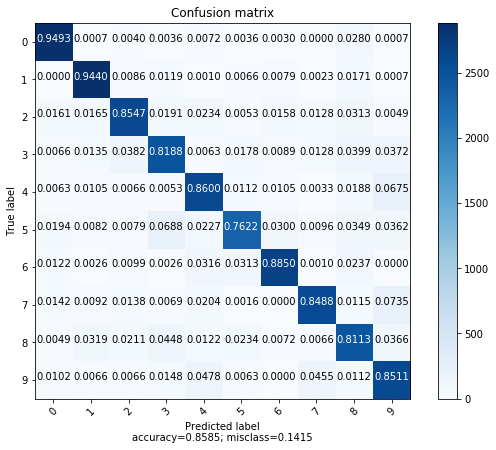

In [38]:
conf_matrix_train = confusion_matrix(y_train, clf.predict(X_train), labels=np.unique(labels))

plot_confusion_matrix(conf_matrix_train, labels_text)

### Test set

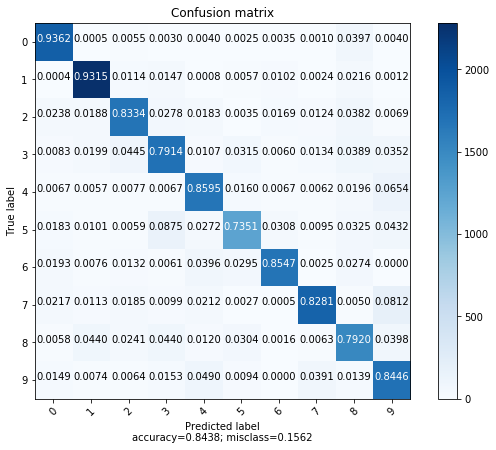

In [39]:
conf_matrix_test = confusion_matrix(y_test, clf.predict(X_test), labels=np.unique(labels))

plot_confusion_matrix(conf_matrix_test, labels_text)

## Generate test predictions

In [40]:
generate_test_predictions(clf, "GradientBoostingClassifier", random_state=random_state)